In [1]:
using CurveFit
using Random

Random.seed!(4309840)

TaskLocalRNG()

# Variance reduction using Multi-Level Monte Carlo method
In this exercise, we intend to use the Multi-Level Monte Carlo (MLMC) method to obtain a  variance reduced Monte Carlo solution to a continuous drift-diffusion process.

$$dX = - X^p dt + \sqrt{2}\ \sigma dW$$

Here, we use Euler Maruyama scheme to discretize this stochastic differential equation, i.e.

$$X(t_0+\Delta t) = X(t_0) - X^p(t_0) \Delta t + \sqrt{2 \Delta t} \ \sigma \xi$$

where $\Delta t$ is the time interval, $t_0$ is the initial time, and $\xi$ is a normally distributed random variable, i.e. $\xi \sim \mathcal{N}(0,1)$ where $\mathcal{N}(0,1)$ is a normal distribution with mean $0$ and variance of $1$.

In order to use MLMC estimate, we need to construct two functions.

## sde: an estimator for the level $l$
The function sde provides an estimate of either the solution $X_l(t=T)$ for $l=l_0$ or the difference between solutions of two consecutive levels  $X_l(t=T)-X_{l-1}(t=T)$ for $l>l_0$ . Here, $n_f$ is number of steps on the fine and $n_c$ on the coarse grid given $l$.

In [2]:
"""
    sde(l, N_samples, [p=1, T=0.1, σ=1.0, x0=0.5])

Solve the SDE
    dX = -X^p*dt + σ*dW
using Euler Maruyama method at time T where dW is the standard Wiener
process at a fine level l and a coarse level l-1.

# Definitions.
N_samples: Number of samples to take.

nf := 2^(l-1) number of steps on the   fine level
nc := nf / 2  number of steps on the coarse level

Pf = X(t=T) using nf steps
Pc = X(t=T) using nc steps

dP = Pf       if l=1
dP = Pf - Pc  otherwise

Return an array ``sums`` that contains:

    sums[1] = nf * N_samples #                           Cost for this level.
    sums[2] = sum(dP)        # Unnormalised expectation value for this level.
    sums[3] = sum(dP^2)      # Unnormalised          variance for this level.
    sums[4] = sum(dP^3)      # Unnormalised      third moment for this level.
    sums[5] = sum(dP^4)      # Unnormalised     fourth moment for this level.
    sums[6] = sum(Pf)        # Unnormalised expectation value for standard MC.
    sums[7] = sum(Pf^2)      # Unnormalised    variance value for standard MC.
"""
function sde(l, N_samples, p=1, T=0.1, σ=1.0, x0=0.5)
    nf = 2 ^ (l-1)
    Δt = T / nf

    sums = zeros(7)
    X0 = x0 * ones(N_samples)

    X_fine = copy(X0)
    X_coarse = copy(X0)
    if l == 1
        dWf = √(Δt) * randn(N_samples)
        X_fine .= X_fine .- X_fine .^ p .* Δt .+ sqrt(2.0) * σ * dWf
    else
        nc = Int(nf / 2)
        Δtc = T / nc
        for n = 1:nc
            # Two fine steps.
            dWf0 = randn(N_samples)
            dWf1 = randn(N_samples)
            @. X_fine = X_fine - X_fine^p * Δt + √(2*Δt) * σ * dWf0
            @. X_fine = X_fine - X_fine^p * Δt + √(2*Δt) * σ * dWf1

            # One coarse step.
            dWc = (dWf0 .+ dWf1) ./ √(2)
            @. X_coarse = X_coarse - X_coarse^p * Δtc + √(2*Δtc) * σ * dWc
        end
    end

    dP = X_fine .- X_coarse
    Pf = copy(X_fine)

    if l == 1
        dP .= Pf
    end

    return (
        cost=nf * N_samples,
        expectation=sum(dP),
        variance=sum(dP .^ 2),
        third_moment=sum(dP .^ 3),
        fourth_moment=sum(dP .^ 4),
        mc_expectation=sum(Pf),
        mc_variance=sum(Pf .^ 2)
    )
end

sde

In [3]:
sde(3, 2000)

(cost = 8000, expectation = 1.496019956555917, variance = 0.11669399314765475, third_moment = 0.0002558492088036896, fourth_moment = 2.041881292703492e-5, mc_expectation = 897.5820774775166, mc_variance = 761.7798465128114)

## mlmc: the MLMC algorithm

In [4]:
function mlmc(Lmin, Lmax, N0, eps, p=1)
    # Allocate memory.
    # n_samples is the total number of samples at each level drawn so far
    # throughout the experiment.
    n_samples = zeros(Int32, Lmax)
    sample_sum = zeros(Float32, Lmax)
    sample_sum_squares = zeros(Float32, Lmax)
    # dNl is the number of samples to be taken per level.
    dNl = zeros(Int, Lmax)
    sample_mean = zeros(Float32, Lmax)
    sample_var = zeros(Float32, Lmax)

    if Lmin < 3
        println("error: needs Lmin >= 3")
        exit(1)
    end
    
    if Lmax < Lmin
        println("error: needs Lmax >= Lmin")
        exit(1)
    end
    
    if N0 <= 0 || eps <= 0.0
        println("error: needs N > 0, eps > 0")
        exit(1)
    end

    L = Lmin

    # α is the exponent that characterises the convergence of the
    # expectation value we are interested in.
    # β is the exponent that allows to estimate the convergence behaviour
    # of the variance for the new level when adding a finer level.
    # γ is the exponent that allows to estimate the convergence behaviour
    # of the cost for the new level when adding a finer level.
    # β, γ give a first estimate how many samples to pick per level when
    # a new level is added. Therefore, they help to reduce the runtime.
    α = 0.0
    β = 0.0
    γ = 0.0
    θ = 0.25

    Nl = zeros(Int, Lmax)
    Cl = zeros(Lmax)
    NlCl = zeros(Lmax)
    dNl[1:Lmin] .= N0

    converged = false
    while !converged
        # Take dNl samples in each level and
        # update the statistics.
        for l = 1:L
            if dNl[l] > 0
                sums = sde(l, dNl[l], p)
                n_samples[l] += dNl[l]
                sample_sum[l] += sums.expectation
                sample_sum_squares[l] += sums.variance
                NlCl[l] += sums.cost
            end
        end

        for l = 1:L
            if n_samples[l] > 0
                sample_mean[l] = abs(sample_sum[l] / n_samples[l])
                # Var[X] = E[X^2] - E[X]^2
                sample_var[l] = max(sample_sum_squares[l] / n_samples[l] - sample_mean[l]^2, 0.0)
                Cl[l] = NlCl[l] / n_samples[l]
            end
            if l > 2
                sample_mean[l] = max(sample_mean[l], 0.5 * sample_mean[l-1] / (2^α))
            end
        end

        # Update the optimal number of samples to take.
        s = sum(.√(sample_var .* Cl))
        for l = 1:L
            dNl[l] = ceil(max(0.0, √(sample_var[l] / Cl[l]) * s / ((1.0 - θ) * eps^2) - n_samples[l]))
        end

        # Fit convergence exponents.
        xl = [l * 1.0 for l = 2:L]
        yl = -log2.(sample_mean[2:L])
        fit = linear_fit(xl, yl)
        α = max(fit[2], 0.5)

        yl = -log2.(sample_var[2:L])
        fit = linear_fit(xl, yl)
        β = max(fit[2], 0.5)

        yl = log2.(Cl[2:L])
        fit = linear_fit(xl, yl)
        γ = max(fit[2], 0.5)

        # Convergence metric:
        # L1-norm of the additional number of samples to be taken - 1% of samples taken so far per level.
        # We are converged when the convergence metric is < 1e-5.
        sr = 0
        for l = 1:L
            sr += max(0, dNl[l] - (0.01 * n_samples[l]))
        end

        if abs(sr) < 1e-5
            converged = true
            rem = sample_mean[L] / (2^α - 1.0)
            if rem > √(θ) * eps
                if L == Lmax
                    println("*** failed to achieve weak convergence ***")
                else
                    # Only the number of samples per level has converged, but not the error.
                    # We need to add a finer level and calculate the number of samples to
                    # take next.
                    converged = false
                    L += 1
                    sample_var[L] = sample_var[L-1] / (2^β)
                    Cl[L] = Cl[L-1] * (2^γ)
                    s = sum(.√(sample_var .* Cl))
                    for l = 1:L
                        dNl[l] = ceil(max(0.0, √(sample_var[l] / Cl[l]) * s / ((1.0 - θ) * eps^2) - n_samples[l]))
                    end
                end
            end
        end
    end

    # Calculate the final estimate ogf the expactation value in which we're interested.
    P = 0.0
    for l = 1:L
        P += sample_sum[l] / n_samples[l]
        Nl[l] = n_samples[l]
        Cl[l] = NlCl[l] / Nl[l]
    end
    return P, Nl[1:L], Cl[1:L], sample_var[1:L], α, β, γ
end

mlmc (generic function with 2 methods)

In [5]:
mlmc(3, 10, 200, 0.001, 1)

(0.453101126186084, [295491, 7154, 2539], [1.0, 2.0, 4.0], Float32[0.20039643, 0.00024176434, 5.7589583f-5], 1.3355331420898438, 2.0697269439697266, 1.0)

## Plot the results for case $p=1$

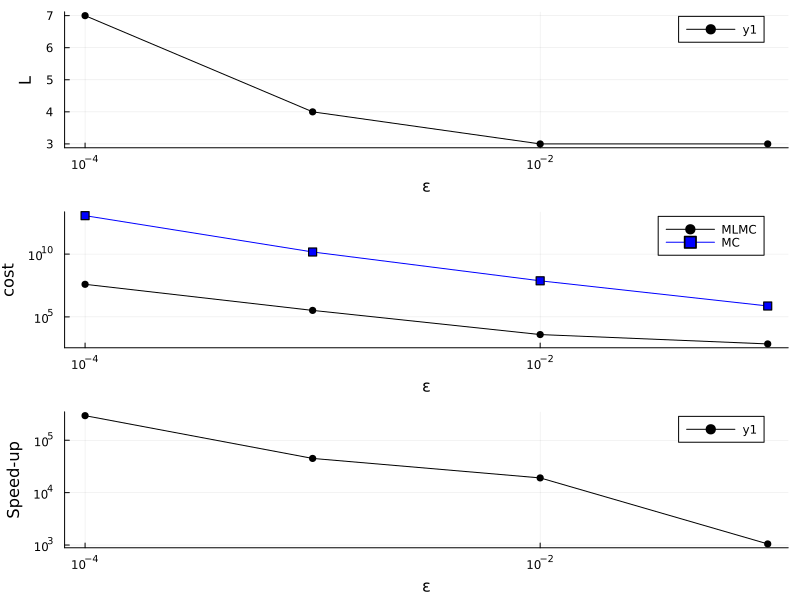

In [6]:
using Plots
using Random
using CurveFit

p = 1
eps = [1e-1, 1e-2, 1e-3, 1e-4]
levels = zeros(Int, length(eps))
costs = zeros(length(eps))
costs_sd = zeros(length(eps))

for (i, ε) in enumerate(eps)
    P, Nl, Cl, Vl, alpha, beta, gamma = mlmc(3, 10, 100, ε, p)
    L = length(Nl)
    levels[i] = L
    costs[i] = sum(Nl .* Cl)

    # Sample cost of standard MC at Lth level
    Ntest = 10000
    sums = sde(L, Ntest, p)
    varL = max(sums[7] / Ntest - (sums[6] / Ntest)^2, 1e-10)
    NlCl = sums[1]
    costs_sd[i] = NlCl * varL / ε^2
end

# Plot levels vs. ε
plt_levels = plot(eps, levels, color="black", ylabel="L", xlabel="ε", marker=:circle)
xaxis!(plt_levels, :log)
yaxis!(plt_levels, integer=true)

# Plot costs and costs_sd vs. ε
plt_costs = plot(eps, costs, color="black", label="MLMC", marker=:circle)
plot!(eps, costs_sd, color="blue", label="MC", xlabel="ε", ylabel="cost", marker=:square)
xaxis!(plt_costs, :log)
yaxis!(plt_costs, :log)

# Plot Speed-up vs. ε
speedup_p1 = costs_sd ./ costs
plt_speedup_p1 = plot(eps, speedup_p1, color="black", ylabel="Speed-up", xlabel="ε", marker=:circle)
xaxis!(plt_speedup_p1, :log)
yaxis!(plt_speedup_p1, :log)

plt = plot(plt_levels, plt_costs, plt_speedup_p1, layout=(3, 1), size=(800, 600))
savefig("plot_p=1.png")
plt

## Plot the results for case $p=3$

In [7]:
using Plots
using Random
using CurveFit

p = 3
eps = [1e-1, 1e-2, 1e-3, 1e-4]
levels = zeros(Int, length(eps))
costs = zeros(length(eps))
costs_sd = zeros(length(eps))

for (i, ε) in enumerate(eps)
    P, Nl, Cl, Vl, alpha, beta, gamma = mlmc(3, 10, 100, ε, p)
    L = length(Nl)
    levels[i] = L
    costs[i] = sum(Nl .* Cl)

    # Sample cost of standard MC at Lth level
    Ntest = 10000
    sums = sde(L, Ntest, p)
    varL = max(sums[7] / Ntest - (sums[6] / Ntest)^2, 1e-10)
    NlCl = sums[1]
    costs_sd[i] = NlCl * varL / ε^2
end

# Plot levels vs. ε
plt_levels = plot(eps, levels, color="black", ylabel="L", xlabel="ε", marker=:circle)
xaxis!(plt_levels, :log)
yaxis!(plt_levels, integer=true)

# Plot costs and costs_sd vs. ε
plt_costs = plot(eps, costs, color="black", label="MLMC", marker=:circle)
plot!(eps, costs_sd, color="blue", label="MC", xlabel="ε", ylabel="cost", marker=:square)
xaxis!(plt_costs, :log)
yaxis!(plt_costs, :log)

# Plot Speed-up vs. ε
speedup_p3 = costs_sd ./ costs
plt_speedup_p3 = plot(eps, speedup_p3, color="black", ylabel="Speed-up", xlabel="ε", marker=:circle)
xaxis!(plt_speedup_p3, :log)
yaxis!(plt_speedup_p3, :log)

plot(plt_levels, plt_costs, plt_speedup_p3, layout=(3, 1), size=(800, 600))
savefig("plot_p=3.png")

"/home/renato/Dokumente/ETH/PhD/TA/HS_22_23/icp-exercises/exercise_sheets_2023/07/sol/plot_p=3.png"

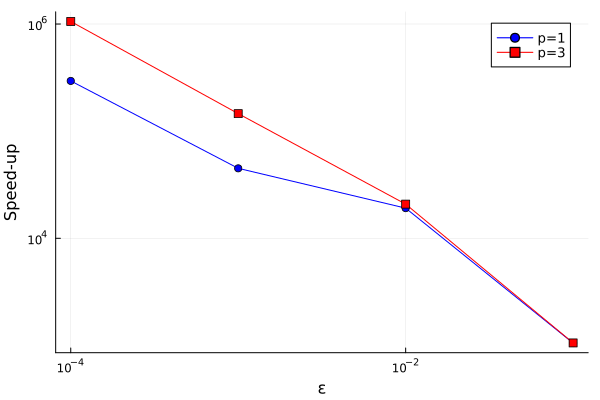

In [8]:
plt_speedup = plot(eps, speedup_p1, color="blue", label="p=1", marker=:circle,legendfontsize=9)
plot!(eps, speedup_p3, color="red", label="p=3", xlabel="ε", ylabel="Speed-up", marker=:square,legendfontsize=9)
xaxis!(plt_speedup, :log)
yaxis!(plt_speedup, :log)

# Set GR backend options for size and resolution
gr(size=(400, 300), dpi=300)

savefig("plot_speedup.png")
plt_speedup